In [1]:
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install matplotlib

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import kagglehub
import ipaddress
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt

In [3]:
file_path = "bank_transactions_data_2.csv"

dataset = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "valakhorasani/bank-transaction-dataset-for-fraud-detection",
  file_path,
)

print("First 5 records:", dataset.head())

/tmp/ipython-input-3282971192.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  dataset = kagglehub.load_dataset(


Using Colab cache for faster access to the 'bank-transaction-dataset-for-fraud-detection' dataset.
First 5 records:   TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerA

In [4]:
print(dataset.shape)

(2512, 16)


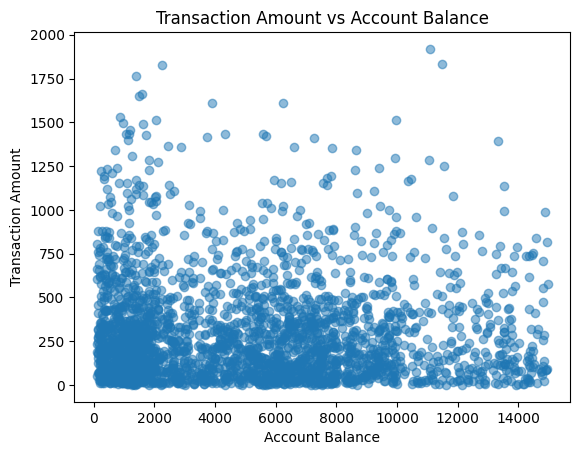

In [5]:
# Scatter Graph of transaction amount and the balance in the account
plt.figure()
plt.scatter(dataset["AccountBalance"], dataset["TransactionAmount"], alpha=0.5)
plt.xlabel("Account Balance")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amount vs Account Balance")
plt.show()

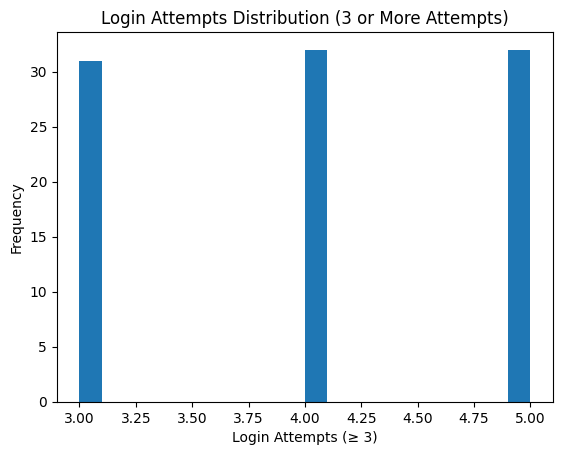

In [6]:
#Histogram of more than 3 login attempts
dataset_login = dataset[dataset["LoginAttempts"] >= 3]
plt.figure()
plt.hist(dataset_login["LoginAttempts"], bins=20)
plt.xlabel("Login Attempts (≥ 3)")
plt.ylabel("Frequency")
plt.title("Login Attempts Distribution (3 or More Attempts)")
plt.show()

In [7]:
#Feature Engineering
dataset["TransactionDate"] = pd.to_datetime(dataset["TransactionDate"], errors="coerce")
dataset["PreviousTransactionDate"] = pd.to_datetime(dataset["PreviousTransactionDate"], errors="coerce")

dataset["tx_hour"] = dataset["TransactionDate"].dt.hour
dataset["tx_dayofweek"] = dataset["TransactionDate"].dt.dayofweek

dataset["secs_since_prev_tx"] = (
    dataset["TransactionDate"] - dataset["PreviousTransactionDate"]
).dt.total_seconds().abs()

dataset["secs_since_prev_tx"] = dataset["secs_since_prev_tx"].clip(0, 60*60*24*365)

In [8]:
dataset_model = dataset.drop(
    columns=["TransactionID", "TransactionDate", "PreviousTransactionDate", "IP Address"],
    errors="ignore"
)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [11]:
#Preprocessing
numeric_features = dataset_model.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = dataset_model.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

X = preprocessor.fit_transform(dataset_model)
print("Preprocessed X shape:", X.shape)

Numeric features: ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'secs_since_prev_tx']
Categorical features: ['AccountID', 'TransactionType', 'Location', 'DeviceID', 'MerchantID', 'Channel', 'CustomerOccupation']
Preprocessed X shape: (2512, 1334)


In [12]:
X_dense = X.toarray() if hasattr(X, "toarray") else X
print("Dense matrix shape (for AE):", X_dense.shape)

Dense matrix shape (for AE): (2512, 1334)
